# Install Libraries if Needed (Only Run Once)

In [ ]:
# !pip install -U deepxde

# Import Libraries

In [1]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import io
import re
import os

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint
import matplotlib.tri as tri
from mpl_toolkits import mplot3d
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Poisson Equation
$$
\nabla^2 u(x,y) = -1,\quad (x,y) \in \Omega, \\
u(x,y) = 0, \quad (x,y) \in \partial \Omega, \\
\Omega = [-1, 1]^2 \ \backslash \ [0,1]^2
$$

# Define PDE

In [3]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return -dy_xx - dy_yy - 1

# Define Geometry

In [6]:
geom = dde.geometry.Polygon([[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]])

<IPython.core.display.Javascript object>


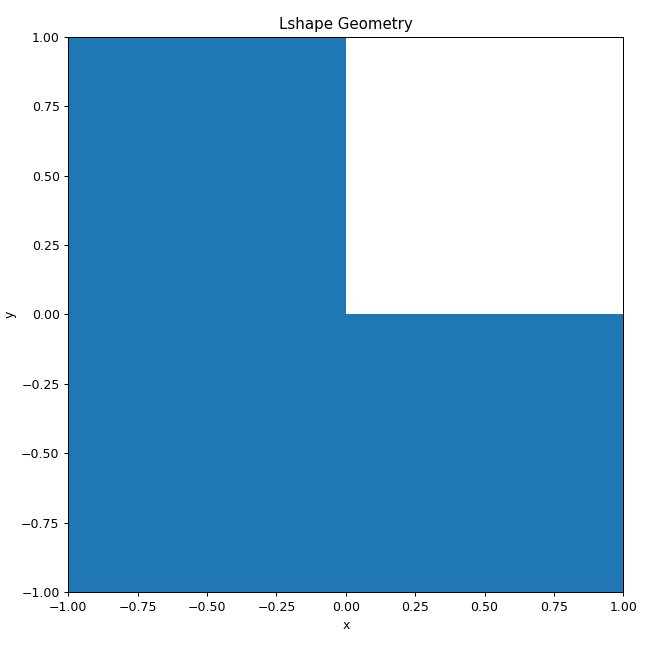

In [7]:
plt.figure(figsize=(8,8))
# plt.axis('equal')

plt.fill(geom.vertices[:,0], geom.vertices[:,1])
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lshape Geometry') 
plt.tight_layout()

# Define BC

In [9]:
def boundary(_, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, lambda x: 0, boundary)

# Define Data (PDE + BC + Geometry)

In [10]:
data = dde.data.PDE(geom, pde, bc, num_domain=25000, num_boundary=5000, num_test=1500)

/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5008=5008. 
  warnings.warn("The balance properties of Sobol' points require "


# Define Network Architecture

In [11]:
net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")

# Define Model (Data + Net)

In [12]:
model = dde.Model(data, net)

# Define Paths

In [13]:
save_dir = 'Poisson_Lshape'
model_name = 'model'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
ckpt_path = tf.train.latest_checkpoint(save_dir)
loss_fname = 'loss_Poisson_Lshape.dat'
train_fname = 'train_Poisson_Lshape.dat'
test_fname = 'test_Poisson_Lshape.dat'
loss_path = os.path.join(save_dir, loss_fname)
train_path = os.path.join(save_dir, train_fname)
test_path = os.path.join(save_dir, test_fname)

# ckpt_path = os.path.join(save_dir, 'checkpoint')
# model.save(model_path)

# Load Model

In [14]:
model.compile("adam", lr=1e-3)
model.restore(ckpt_path, verbose=1)

Compiling model...
Building feed-forward neural network...
'build' took 0.129172 s



/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.133234 s

Restoring model from Poisson_Lshape/model-55343.ckpt ...

INFO:tensorflow:Restoring parameters from Poisson_Lshape/model-55343.ckpt


# Train the Model
Here we train the model twice.  Once with Adam optimizer for initial training.  Then again with L-BFGS-B optimizer for finetuning.

In [27]:
model.compile("adam", lr=0.001)
model.train(epochs=50000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.361917 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [9.50e-01, 5.07e-03]    [9.42e-01, 5.07e-03]    []  
1000      [2.27e-04, 3.43e-03]    [1.64e-04, 3.43e-03]    []  
2000      [1.37e-04, 3.49e-03]    [9.66e-05, 3.49e-03]    []  
3000      [2.25e-04, 2.70e-03]    [1.58e-04, 2.70e-03]    []  
4000      [2.86e-04, 1.89e-03]    [1.85e-04, 1.89e-03]    []  
5000      [1.08e-03, 1.45e-03]    [9.91e-04, 1.45e-03]    []  
6000      [1.86e-04, 5.95e-04]    [1.38e-04, 5.95e-04]    []  
7000      [1.33e-04, 4.47e-04]    [1.06e-04, 4.47e-04]    []  
8000      [1.18e-04, 3.62e-04]    [9.84e-05, 3.62e-04]    []  
9000      [2.41e-04, 3.59e-04]    [2.27e-04, 3.59e-04]    []  
10000     [1.18e-04, 2.95e-04]    [9.55e-05, 2.95e-04]    []  
11000     [1.21e-04, 2.88e-04]    [1.11e-04, 2.88e-04]    []  
12000     [5.32e-05, 2.49e-04]    [4.25e-05, 2.49e-04]    []  
13000     [1.04e-04,

# Save Model

In [29]:
model.save(model_path)

INFO:tensorflow:Poisson_Lshape/model-55343.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'Poisson_Lshape/model-55343.ckpt'

# Plot Loss and Predictions

Saving loss history to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Poisson_Lshape/loss_Poisson_Lshape.dat ...
Saving training data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Poisson_Lshape/train_Poisson_Lshape.dat ...
Saving test data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Poisson_Lshape/test_Poisson_Lshape.dat ...


<IPython.core.display.Javascript object>


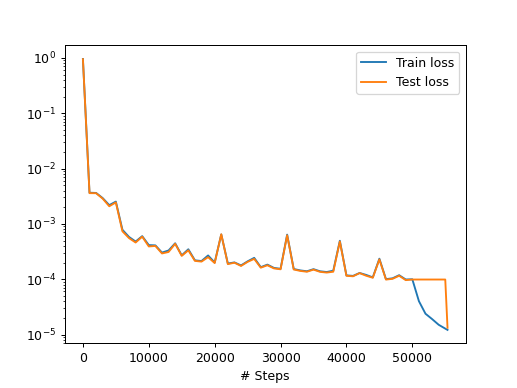

<IPython.core.display.Javascript object>


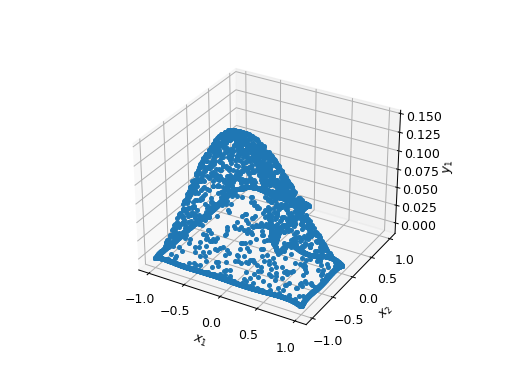

In [28]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname=loss_path, train_fname=train_path, test_fname=test_path)

# Get Predictions

In [15]:
def load_test_data(file='dataset/Poisson_Lshape.npz'):
    data = np.load(file)
    X_test = data['X_test']
    y_test = data['y_ref']
    return X_test, y_test

In [16]:
file = 'dataset/Poisson_Lshape.npz'
X_test, y_test = load_test_data(file)

# Predict on Test Data

In [17]:
y_pred = model.predict(X_test)

# Evaluate on Test Data

In [18]:
not_nan = ~np.isnan(y_test[:,0])

print("L2 relative error:", dde.metrics.l2_relative_error(y_test[not_nan], y_pred[not_nan]))

L2 relative error: 0.10896659256409716


# Plot Results

In [19]:
not_nan

array([ True,  True,  True, ..., False, False, False])

In [20]:
X = X_test[not_nan,0]
Y = X_test[not_nan,1]
Y_test = y_test[not_nan,0]
Y_pred = y_pred[not_nan,0]


In [21]:
triang = tri.Triangulation(X, Y)
x_triang = X[triang.triangles].mean(axis=1)
y_triang = Y[triang.triangles].mean(axis=1)
zero = np.zeros_like(x_triang)
triang.set_mask(np.greater(x_triang,zero) & np.greater(y_triang,zero))

<IPython.core.display.Javascript object>


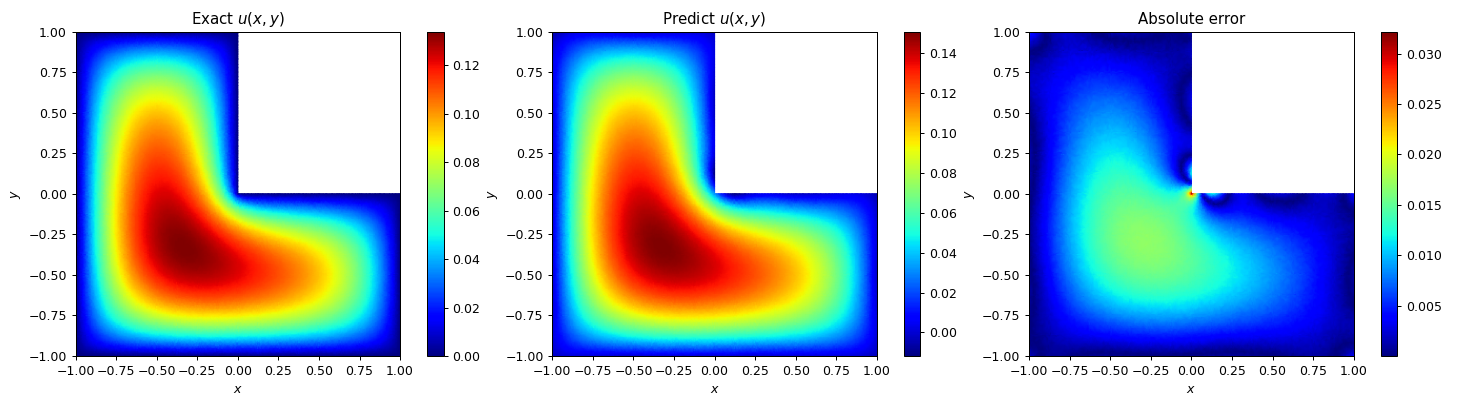

In [22]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
tpc = plt.tripcolor(triang, Y_test, cmap='jet', shading='gouraud')
plt.colorbar(tpc)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Exact $u(x,y)$')
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.tight_layout()
# plt.axis('off')

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
tpc = plt.tripcolor(triang, Y_pred, cmap='jet', shading='gouraud')
plt.colorbar(tpc)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Predict $u(x,y)$')
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.tight_layout()
# plt.axis('off')

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
tpc = plt.tripcolor(triang, abs(Y_pred - Y_test), cmap='jet', shading='gouraud')
plt.colorbar(tpc)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error')
plt.axis('square')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.tight_layout()
# plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


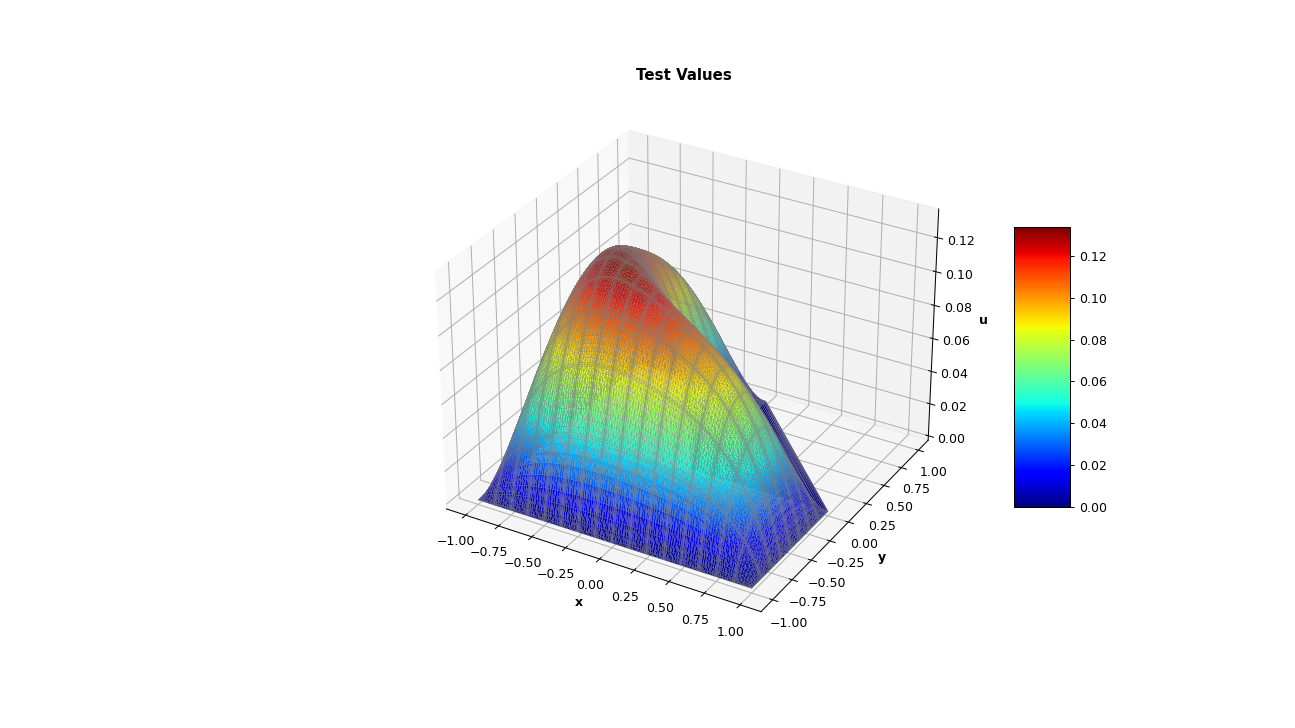

In [23]:
fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(X, Y, Y_test,
                         cmap = 'jet',
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey') 
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Test Values', fontweight='bold')
# Adding labels
ax.set_xlabel('x', fontweight ='bold')
ax.set_ylabel('y', fontweight ='bold')
ax.set_zlabel('u', fontweight ='bold')
plt.show()

<IPython.core.display.Javascript object>


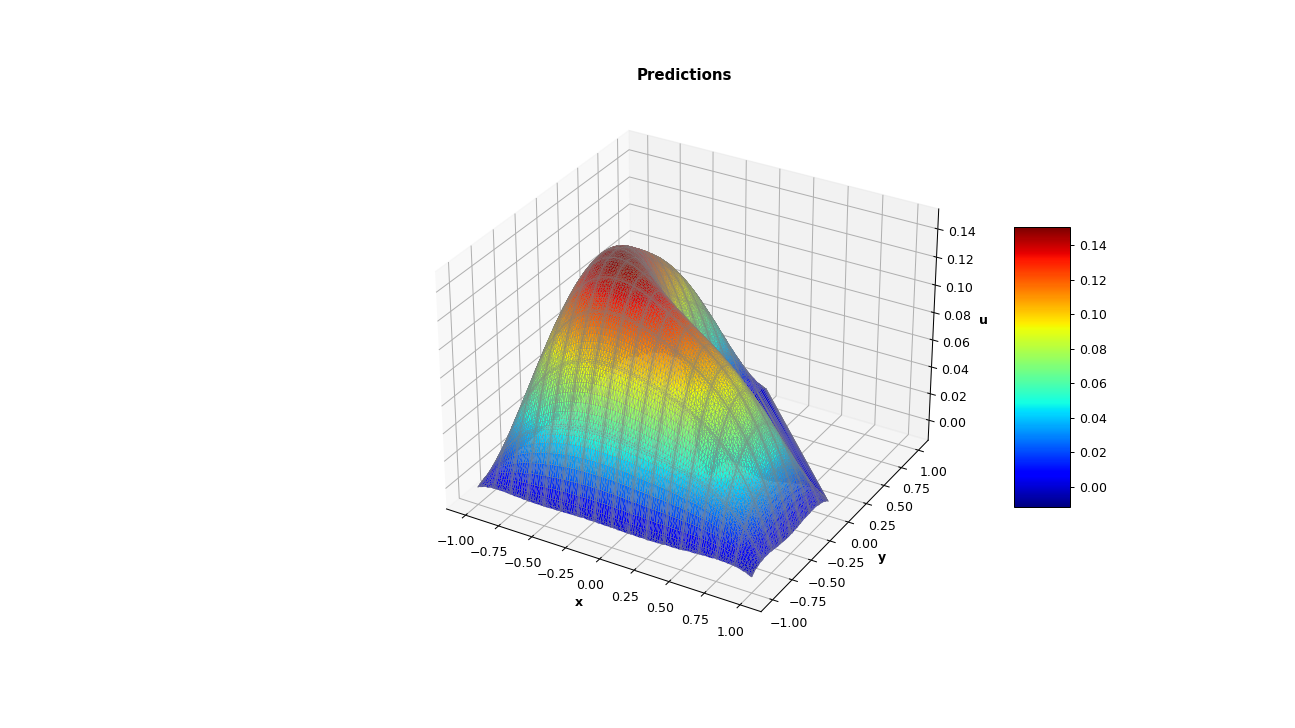

In [24]:
fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(X, Y, Y_pred,
                         cmap = 'jet',
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey') 
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Predictions', fontweight='bold')
# Adding labels
ax.set_xlabel('x', fontweight ='bold')
ax.set_ylabel('y', fontweight ='bold')
ax.set_zlabel('u', fontweight ='bold')
plt.show()

<IPython.core.display.Javascript object>


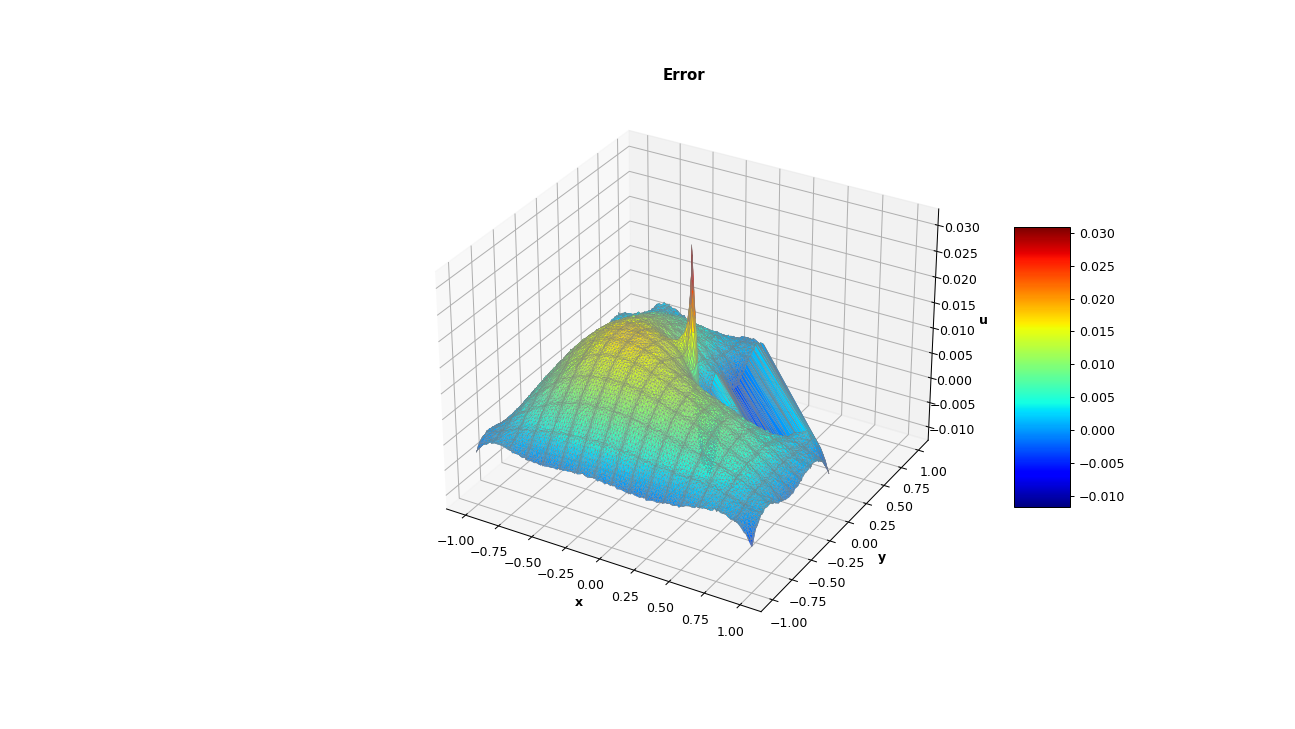

In [25]:
fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(X, Y, Y_pred - Y_test,
                         cmap = 'jet',
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey') 
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Error', fontweight='bold')
# Adding labels
ax.set_xlabel('x', fontweight ='bold')
ax.set_ylabel('y', fontweight ='bold')
ax.set_zlabel('u', fontweight ='bold')
plt.show()